# Data Distribution and Clustering Analysis

This notebook focuses on visualizing the distribution and clustering structure of the ENIGMA-OCD dataset.
Given the high dimensionality of fMRI data (Time x ROIs), meaningful visualization requires feature extraction and dimensionality reduction.

## Methodology
1. **Feature Extraction (Functional Connectivity)**: 
   - Raw fMRI time-series are not temporally aligned across subjects (resting state).
   - We compute the **Functional Connectivity (FC) matrix** (Pearson correlation between ROIs) for each subject.
   - The unique values (upper triangle) of the FC matrix serve as the feature vector for each subject.

2. **Dimensionality Reduction**:
   - We use **t-SNE** (t-Distributed Stochastic Neighbor Embedding) or **UMAP** (Uniform Manifold Approximation and Projection) to project the high-dimensional FC features into 2D space.
   - This allows us to visually inspect if subjects form clusters based on **Site**, **Diagnosis**, **Scanner**, or **Model**.

3. **Quality Control**:
   - We also check the mean signal correlations to ensure no gross outliers.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Try to import UMAP, fall back to t-SNE if not installed
try:
    import umap
    HAS_UMAP = True
    print("UMAP library found. Will use UMAP for visualization.")
except ImportError:
    HAS_UMAP = False
    print("UMAP library not found. Will use t-SNE for visualization.")

/pscratch/sd/p/pakmasha/BrainLM/conda/envs/quantum/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


UMAP library found. Will use UMAP for visualization.


In [2]:
# --- Configuration ---
METADATA_PATH = "/pscratch/sd/p/pakmasha/enigma_quantum/metadata/ENIGMA_QC_final_subject_list.csv"
PARAMS_PATH = "/pscratch/sd/p/pakmasha/enigma_quantum/metadata/ENIGMA_OCD_parameters.csv"
DATA_DIR_TEMPLATE = "/pscratch/sd/p/pakmasha/enigma_quantum_data/{subject_id}/{subject_id}.npy"

# Columns
TARGET_COL = "OCD" 
SITE_COL = "Sample"
SUBJECT_ID_COL = "Unique_ID"

In [3]:
def load_fc_data(metadata_path, data_dir_template, target_col, site_col):
    """
    Loads metadata, loads fMRI npy files, computes FC matrices, and returns flattened upper-triangle features.
    """
    print(f"Loading metadata from {metadata_path}...")
    if not os.path.exists(metadata_path):
        raise FileNotFoundError(f"Metadata file not found at {metadata_path}")
        
    df = pd.read_csv(metadata_path)
    required_cols = [SUBJECT_ID_COL, site_col, target_col]
    df = df.dropna(subset=required_cols)
    
    X_fc = []
    metadata_list = []
    
    print(f"Processing {len(df)} subjects...")
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        subj_id = row[SUBJECT_ID_COL]
        site = row[site_col]
        
        fmri_path = data_dir_template.format(subject_id=subj_id)
        if not os.path.exists(fmri_path):
            continue
            
        try:
            # Load (Time x ROI)
            ts = np.load(fmri_path)
            if ts.ndim != 2:
                continue
                
            # Pearson Correlation: (ROI x ROI)
            # np.corrcoef expects (Variables, Observations), so we transpose ts (Time, ROI) -> (ROI, Time)
            fc_matrix = np.corrcoef(ts.T)
            
            # Valid check
            if np.isnan(fc_matrix).any():
                fc_matrix = np.nan_to_num(fc_matrix)
                
            # Extract upper triangle (flattened)
            upper_inds = np.triu_indices_from(fc_matrix, k=1)
            features = fc_matrix[upper_inds]
            
            X_fc.append(features)
            metadata_list.append(row)
            
        except Exception as e:
            print(f"Error with {subj_id}: {e}")
            
    X_fc = np.array(X_fc)
    df_final = pd.DataFrame(metadata_list)
    
    return X_fc, df_final

# Load Data
try:
    X_fc, df_meta = load_fc_data(METADATA_PATH, DATA_DIR_TEMPLATE, TARGET_COL, SITE_COL)
    print(f"Loaded {len(X_fc)} subjects. Feature shape: {X_fc.shape}")
except Exception as e:
    print(f"Failed to load data: {e}")
    X_fc = None

Loading metadata from /pscratch/sd/p/pakmasha/enigma_quantum/metadata/ENIGMA_QC_final_subject_list.csv...
Processing 2095 subjects...


100%|██████████| 2095/2095 [00:05<00:00, 384.75it/s]


Loaded 1706 subjects. Feature shape: (1706, 50403)


In [4]:
# Load Scanner/Model Parameters and Merge
if X_fc is not None and os.path.exists(PARAMS_PATH):
    print(f"Loading parameters from {PARAMS_PATH}...")
    try:
        df_params = pd.read_csv(PARAMS_PATH)
        
        # Check if merge keys exist
        # df_meta has 'Sample' as the site column (from SITE_COL)
        # df_params is expected to have 'Site'
        if 'Site' in df_params.columns and SITE_COL in df_meta.columns:
            # Drop duplicates in params file just in case to ensure 1-to-1 mapping per site
            df_params_clean = df_params.drop_duplicates(subset=['Site'])[['Site', 'Scanner', 'Model_unified']]
            
            # Merge
            df_meta = df_meta.merge(df_params_clean, left_on=SITE_COL, right_on='Site', how='left')
            print("Successfully merged Scanner and Model information.")
            print("Columns now available:", df_meta.columns.tolist())
        else:
            print(f"Warning: Merge keys missing. Meta has {SITE_COL}, Params has {df_params.columns.tolist()}.")
            
    except Exception as e:
        print(f"Error loading/merging parameters: {e}")
else:
    if X_fc is not None:
        print(f"Parameters file not found at {PARAMS_PATH}, skipping merge.")

Loading parameters from /pscratch/sd/p/pakmasha/enigma_quantum/metadata/ENIGMA_OCD_parameters.csv...
Successfully merged Scanner and Model information.
Columns now available: ['Sample', 'Subject ID', 'Formatted ID', 'Unique_ID', 'OCD', 'Age of onset', 'Medication', 'Y-BOCS', 'Age', 'Age range', 'Sex', 'Education', 'Depression current', 'Depression lifetime', 'Anxiety current', 'Anxiety lifetime', 'Agr_Check', 'Clean', 'Sex_Rel', 'Hoard', 'Ord', 'Site', 'Scanner', 'Model_unified']


In [5]:
# Dimensionality Reduction
if X_fc is not None and len(X_fc) > 0:
    # 1. PCA for initial reduction (optional but recommended for speed before t-SNE)
    print("Running PCA for initial dimensionality reduction (50 components)...")
    pca = PCA(n_components=50)
    X_pca = pca.fit_transform(StandardScaler().fit_transform(X_fc))
    
    # 2. t-SNE or UMAP
    print("Running Manifold Learning...")
    if HAS_UMAP:
        reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
        embedding = reducer.fit_transform(X_fc) 
        method_name = "UMAP"
    else:
        tsne = TSNE(n_components=2, perplexity=30, random_state=42, init='pca', learning_rate='auto')
        embedding = tsne.fit_transform(X_pca) 
        method_name = "t-SNE"
        
    # Add to dataframe
    df_meta['x_emb'] = embedding[:, 0]
    df_meta['y_emb'] = embedding[:, 1]
    
    print(f"{method_name} complete.")

Running PCA for initial dimensionality reduction (50 components)...
Running Manifold Learning...


/pscratch/sd/p/pakmasha/BrainLM/conda/envs/quantum/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP complete.


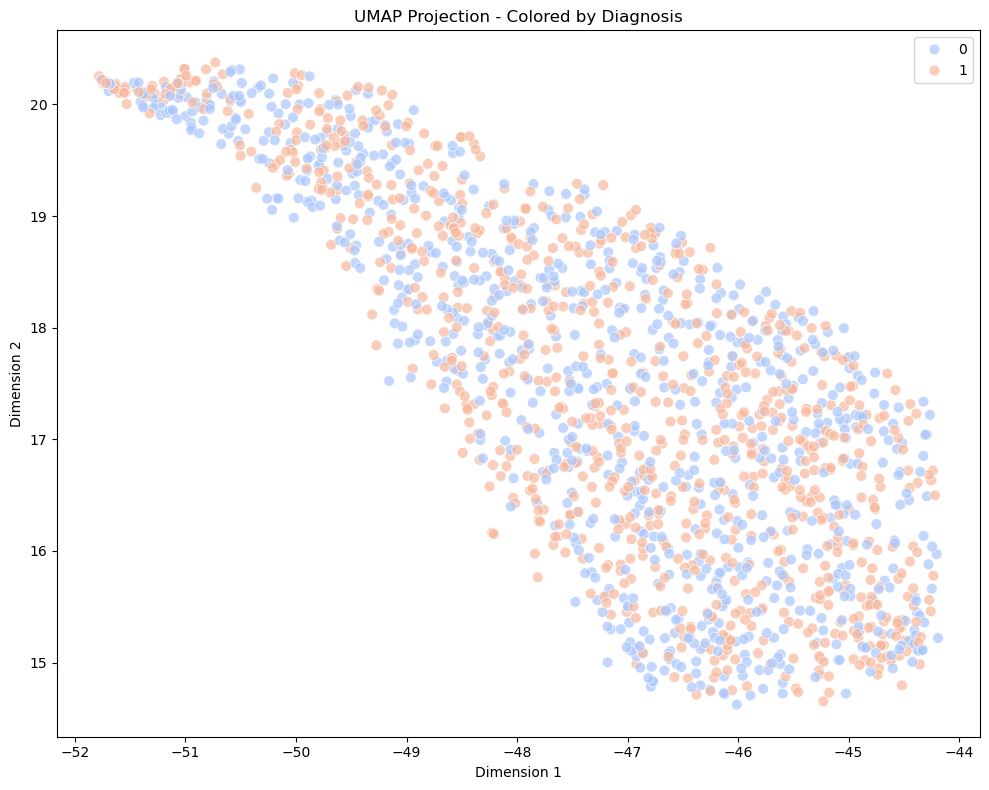

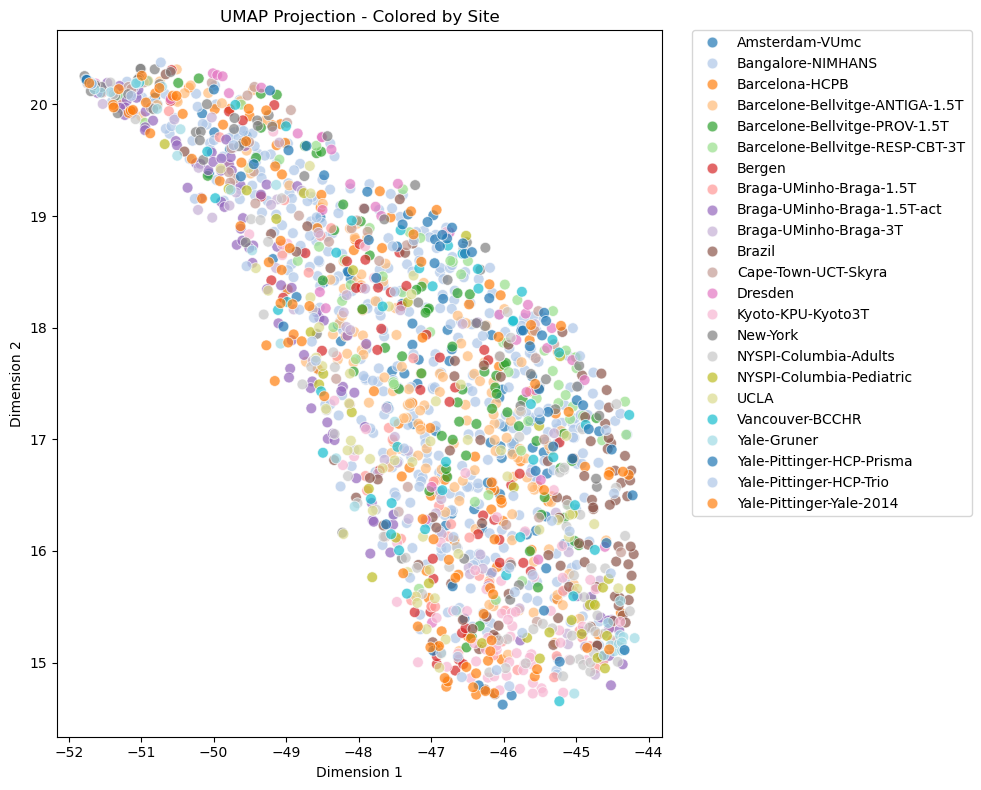

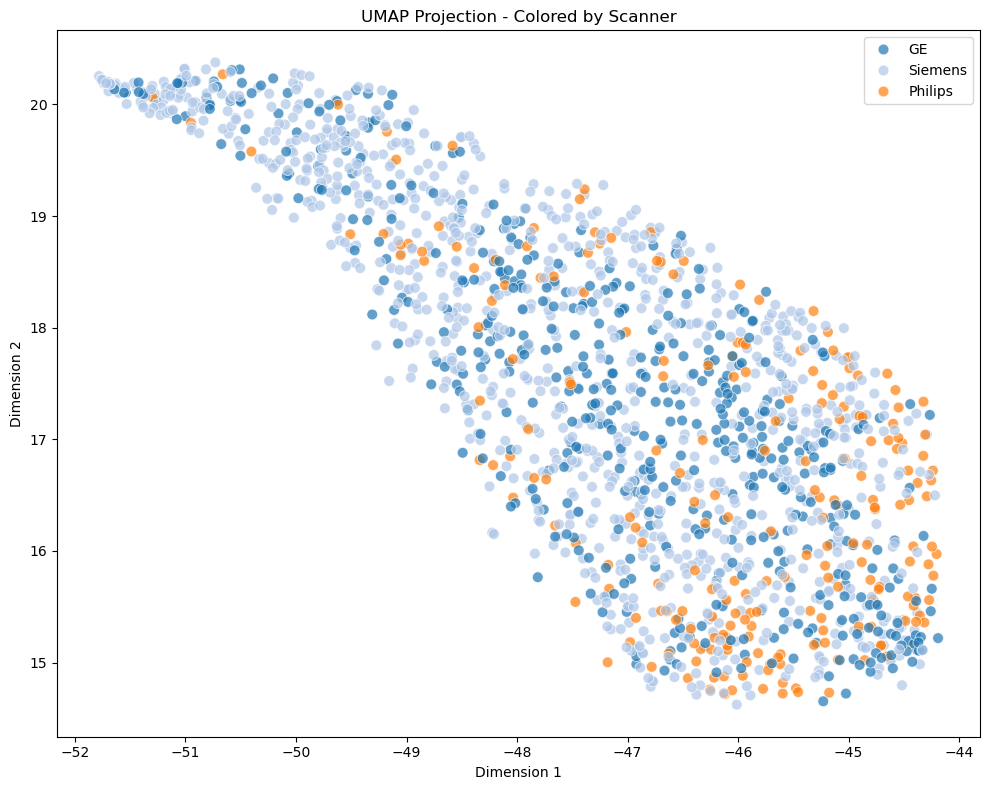

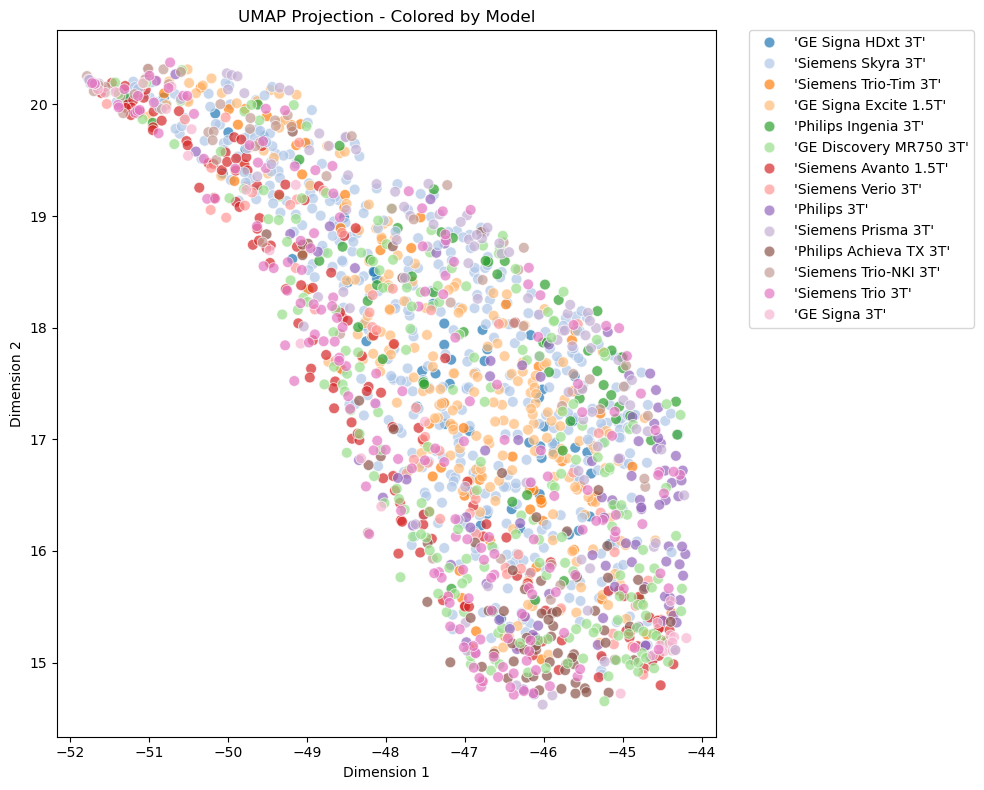

In [6]:
# Plotting Function
def plot_embedding(df, hue_col, title, palette='viridis'):
    if hue_col not in df.columns:
        print(f"Skipping plot: Column '{hue_col}' not found in dataframe.")
        return
        
    plt.figure(figsize=(10, 8))
    
    # Handle high cardinality for palette automatically if needed
    n_colors = df[hue_col].nunique()
    if n_colors > 20 and palette == 'tab20':
         # Fallback to a discrete colormap if tab20 isn't enough, or just let seaborn handle it
         pass

    sns.scatterplot(
        data=df, 
        x='x_emb', 
        y='y_emb', 
        hue=hue_col, 
        palette=palette, 
        alpha=0.7,
        s=60
    )
    plt.title(title)
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    
    # Put legend outside if too many categories
    if n_colors > 10:
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    else:
        plt.legend()
    plt.tight_layout()
    plt.show()

if X_fc is not None:
    # 1. Color by Diagnosis (OCD vs Control)
    plot_embedding(df_meta, TARGET_COL, f'{method_name} Projection - Colored by Diagnosis', palette='coolwarm')
    
    # 2. Color by Site (Sample)
    plot_embedding(df_meta, SITE_COL, f'{method_name} Projection - Colored by Site', palette='tab20')
    
    # 3. Color by Scanner
    plot_embedding(df_meta, 'Scanner', f'{method_name} Projection - Colored by Scanner', palette='tab20')
    
    # 4. Color by Model
    plot_embedding(df_meta, 'Model_unified', f'{method_name} Projection - Colored by Model', palette='tab20')

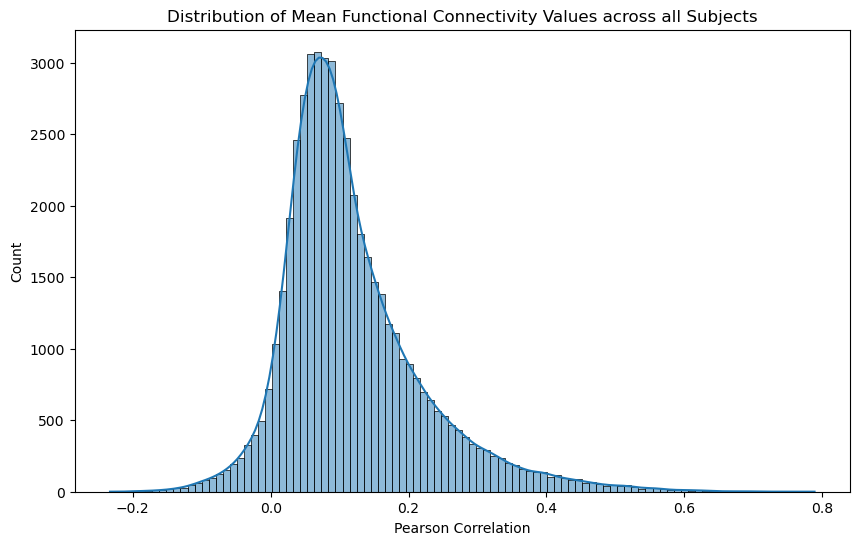

In [7]:
# Extra: Mean FC Matrix Visualization (Quality Check)
if X_fc is not None:
    mean_fc = np.mean(X_fc, axis=0)
    plt.figure(figsize=(10, 6))
    sns.histplot(mean_fc, bins=100, kde=True)
    plt.title("Distribution of Mean Functional Connectivity Values across all Subjects")
    plt.xlabel("Pearson Correlation")
    plt.show()